# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Откройте и изучите файл

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter('ignore')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

data = pd.read_csv('/datasets/users_behavior.csv')
data.head(10)

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


In [3]:
data['calls'] = data['calls'].astype('int')
data['messages'] = data['messages'].astype('int')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   int64  
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   int64  
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 125.7 KB


In [5]:
data.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


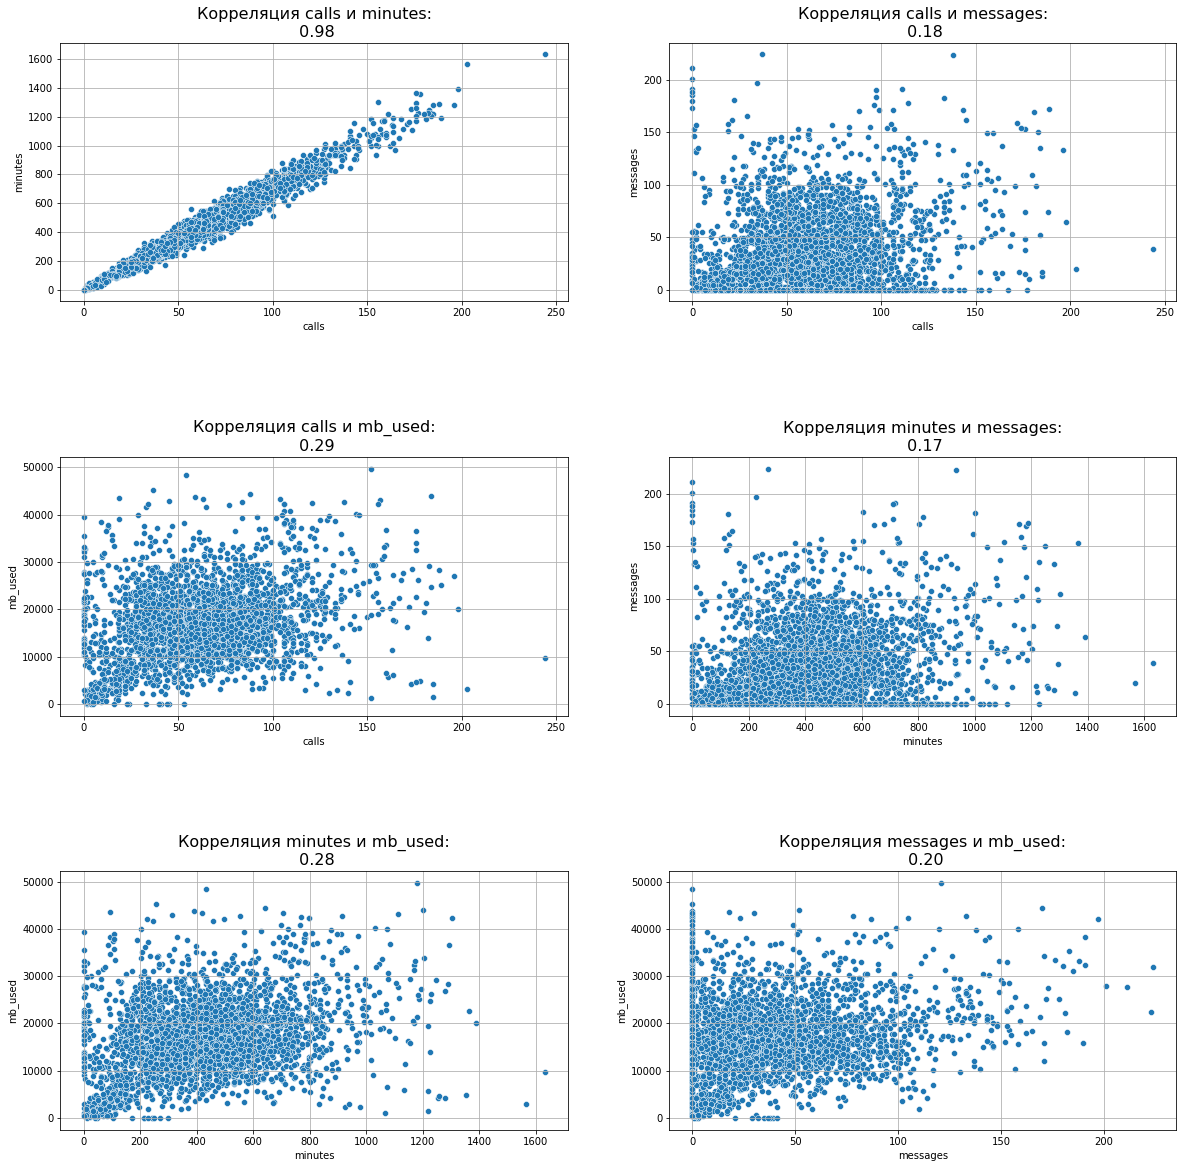

In [6]:
cell = 0
plt.figure(figsize=(20,20))
plt.subplots_adjust(wspace=0.2, hspace=0.6)
data_for_plot = data.drop('is_ultra', axis=1)
used = []

for column in data_for_plot.columns:
    for feature in data_for_plot.columns:
        if (feature != column) and (feature not in used):
            cell += 1  
            plt.subplot(3, 2, cell)
            corr_value = data_for_plot[f'{column}'].corr(data_for_plot[f'{feature}'])
            plt.title(f'Корреляция {column} и {feature}:\n {corr_value:.2f}', fontsize=16)
            sns.scatterplot(x=f'{column}', y=f'{feature}', data=data_for_plot)
            plt.grid(True)
        used.append(column)
plt.show()

Практически максимальная корреляция достигнута у звонков и минут, что не слишком удивительно.  
У остальных же признаков линейная связь крайне мала.

## Разбейте данные на выборки

In [7]:
features = data.drop(['is_ultra'], axis=1)
target = data['is_ultra']

features_train, features_test,\
target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=42)

# Разбиение на валид-выборку производить не будем, так как используем GridSearchCV
# со встроенной кросс-валидацией.

In [8]:
features_train.shape

(2410, 4)

In [9]:
features_test.shape

(804, 4)

Размерность выборок удовлетворительная.

## Исследуйте модели

In [11]:
labels = ['DecisionTreeClassifier', 'RandomForestClassifier']
results = []
parameters = []

### Решающее дерево

In [12]:
tree_params = {'criterion':['gini','entropy'],
               'max_depth':range(1,6)}

tree_clf = GridSearchCV(DecisionTreeClassifier(random_state=42), tree_params)
tree_clf.fit(features_train, target_train)

results.append(tree_clf.best_score_)
parameters.append(tree_clf.best_params_)

### Случайный лес

In [13]:
forest_params = {'max_depth':range(1,10),
                 'min_samples_leaf':[1, 2, 4],
                 'min_samples_split':[2, 5],
                 'n_estimators':range(1,10)}

forest_clf = GridSearchCV(RandomForestClassifier(random_state=42), forest_params)
forest_clf.fit(features_train, target_train)

results.append(forest_clf.best_score_)
parameters.append(forest_clf.best_params_)

In [14]:
pd.DataFrame({'Classifier':labels, 'Accuracy':results, 'Parameters':parameters})

,Classifier,Accuracy,Parameters
0,DecisionTreeClassifier,0.790456,"{'criterion': 'entropy', 'max_depth': 5}"
1,RandomForestClassifier,0.804979,"{'max_depth': 9, 'min_samples_leaf': 2, 'min_s..."


**Вывод:** Лучшей моделью оказался RandomForestClassifier с accuracy, равным 0.804979, и параметрами:

In [11]:
forest_clf.best_params_

{'max_depth': 9,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 9}

## Проверьте модель на тестовой выборке

In [12]:
forest_clf = RandomForestClassifier(random_state=42, n_estimators=9, max_depth=8, min_samples_leaf=2, min_samples_split=2)
forest_clf.fit(features_train, target_train)

predictions_test = forest_clf.predict(features_test)
result_test = accuracy_score(predictions_test, target_test)
print('Accuracy RandomForestClassifier:', result_test)

Accuracy RandomForestClassifier: 0.8159203980099502


## (бонус) Проверьте модели на адекватность

In [13]:
dummy_clf = DummyClassifier(random_state=42)
dummy_clf.fit(features_train, target_train)

predictions_test = dummy_clf.predict(features_test)
result_test = accuracy_score(predictions_test, target_test)
print('Accuracy DummyClassifier:', result_test)

Accuracy DummyClassifier: 0.7027363184079602


**Вывод:** Accuracy модели RandomForestClassifier оказалась выше, чем у DummyClassifier.  
Следовательно, модель абсолютно адекватна.